In [2]:
# Essential plotting and scientific libraries
import matplotlib.pyplot as pl
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline
import numpy as np

from numpy import fft

from skimage.io import imread
from skimage.transform import resize

# IPython display imports
from ipywidgets import interact, FloatSlider, IntSlider, RadioButtons, Button, HBox, VBox, Checkbox
from IPython.display import Image, display, clear_output


from scipy.misc import face
face = face() # An example image we can use
from scipy.signal import convolve2d

import wave

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; height:95%; }</style>"))

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

HTML('''<script>
    code_show=true; 
    function code_toggle() {
         if (code_show){
         $('div.input').hide();
         } else {
         $('div.input').show();
         }
         code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
    ''')

## Describing Imaging Systems
<div style="float: left; width: 45%;">
<br>
<ul>
<li> No imaging system is perfect!  <br><br>
<li> Images only provide a reasonable approximation of the underlying object we are trying to capture. <br><br>
<li> For example, medical images typically provide some information about a particular biological property of the tissue at a given position in space, $(x, y)$ <br><br>
</ul>
</div>
<div style="float: right; width: 50%;">
 <img src='images/medical_image_examples.jpg' width = '80%'>
</div>

## Describing Imaging Systems
<div style="float: left; width: 45%;">
<br>
<ul>
    <li> In the following slides we introduce a general formulation for characterising imaging systems.<br><br>
    <li> We deonte the <b>object</b> as $f(\alpha, \beta)$ , and the <b>image</b> as $g(x, y)$<sup>1</sup><br><br>
    <li> We also typically assume that $f(\alpha, \beta) \in \mathbb{R}^{+}$ and $g(x, y) \in \mathbb{R}^{+}$<br><br>
    <li> In its most general sense, the imaging system can be thought of as an operator, $\mathcal{H}$, operating on the opbject to produce the image.<br><br>
</ul>
<hr></hr>
<sup>1. Here we assume we are working with 2D images, but these methods are applicable to 3 or more dimensions as well!</sup>
</div>
<br><br><br>
<div style="float: right; width: 50%;">
<img src='images/image_object.jpg' width = '90%'>
</div>

## Linear Imaging Systems
<ul>
    <li>Consider now that the same imaging system is used to capture images, $g_{1}(x, y)$ and $g_{2}(x, y)$, of two objects, $f_{1}(\alpha, \beta)$ and $f_{2}(\alpha, \beta)$ respectively.<br><br>
    <li> A <b>linear imaging system</b> is one that satisfies the following property:<br><br>
\begin{align}
\mathcal{H}\left(g_{1} + g_{2}\right) &= \mathcal{H}\left(g_{1}\right) + \mathcal{H}\left(g_{2}\right) \\ 
        &= f_{1} + f_{2}
\end{align}<br>
     <li> For example, in PET imaging, if the concentration of radioactive tracer doubles, then so does the intensity on the final image.  Another example could be doubling of the exposure time when taking a picture (although there will be a limit!)<br><br>
     <li> In practise nearly all imaging systems are considered to be linear.
</ul>

## Point-Spread Function
<div style="float: left; width: 50%;">
<br>
<ul>
    <li> Lets go back to our example of the pin-hole camera with a finite aperture.<br><br>
    <li> What happens if we use a point-source at position $(\alpha, \beta)$ as the object: $f(\alpha', \beta') = \delta(\alpha' - \alpha, \beta' - \beta)$?<br><br>
    <li> We will end up with the <b>point-spread function</b> (PSF) describing the imaging-system for the location of the point source, $h(x, y; \alpha, \beta)$.<br><br>
    <li> The final image will be the sum (integral) of the contribution from all point-sources that make up the object (assuming the imaging system is linear):
    $$
    g(x, y) = \iint\limits_{-\infty}^{\infty} h(x, y; \alpha, \beta)\cdot f(\alpha, \beta)\text{d}\alpha\text{d}\beta
    $$
</ul>
</div>
<br><br><br>
<div style="float: right; width: 40%;">
    <img src='images/pinhole_projection.jpg' width = '90%'>
</div>

## Shift Invariance
<div style="float: left; width: 40%;">
<br>
<ul>
    <li>If the PSF is <b>shift invariant</b> then $h$ will not change for different positions in the source frame-of-reference.<br><br>
    <li> Instead, the final image will be a <b>convolution</b> of the shift-invariant PSF with the object:<br><br>
        \begin{align}
            g(x, y) &= \iint\limits_{-\infty}^{\infty} h(x-\alpha, y-\beta)\cdot f(\alpha, \beta)\text{d}\alpha\text{d}\beta            
        \end{align}
        <br>
    <li> In practice nearly all imaging systems are considered to be shift invariant (even if it is know they are not!).
</ul>
</div>
<div style="float: right; width: 50%;">
    <img src='images/PSF_examples.jpg' width = '90%'>
</div>

## Example of the PSF
This example taken from earlier on works as a good example of the (shift-invariant) PSF in action.  Using a Guassian distribution as the PSF and increasing the variance of the distribution appears to make the image more blurry!

In [2]:
# Convert the red-channel of the 'face' to a floating point array (value 0 to 1):
face_R = face[:, :, 0].astype('float32')/255

# Make it smaller to speed thing up a little....
face_R = resize(face_R, (face_R.shape[0] / 5, face_R.shape[1] / 5))

PSF_variance_slider = FloatSlider(min=0.0, max=30, step=0.5, value=0, continuous_update=False)
PSF_variance_slider.add_class("mytext")
    
# decorate the plot function with an environment from the UIs:
@interact(variance=PSF_variance_slider)
def convolute_PSF(variance):
    
    # We can't actually use zero here so just make very small.
    if variance == 0.0:
        variance = 1e-10
    
    # convolve with a disk of varying radius
    x = np.linspace(-20, 20, 41)
    X, Y = np.meshgrid(x, x)
    
    gaussian = (1.0 / (2*np.pi*np.sqrt(variance))) * np.exp(-0.5 * (X**2 + Y**2) / variance)
    
    f = pl.figure(figsize = (25, 6))
    ax1 = f.add_subplot(131) 
    ax1.imshow(gaussian / gaussian.max(), cmap = 'gray', clim = (0, 1), interpolation = 'None')
    ax1.set_title(r'$PSF, h(x - \alpha, y - \beta)$', fontsize = 20.0)
    
    ax2 = f.add_subplot(132)
    ax2.imshow(face_R, cmap = 'gray', interpolation = 'None')
    ax2.set_title(r'$f(\alpha, \beta)$', fontsize = 20.0)
    
    ax3 = f.add_subplot(133)
    ax3.imshow(convolve2d(face_R, gaussian, mode='same'), cmap = 'gray', interpolation = 'None')
    ax3.set_title(r'$g(x, y)$', fontsize = 20.0)
    
    pl.show()

/Users/adminmblackledge/miniconda2/envs/main/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description=u'variance', max=30.0, step=0.5, _dom_classes=('mytext',)), Output()), _dom_classes=('widget-interact',))

## Transfer Functions
<ul>
    <li> Recall the convoilution theorem, which states that the Fourier transform of the convolution between two signals, $f$ and $h$, is equal to the product of the fourier trannform of each signal, $F$ and $H$ respectively. <br><br>
    <li> In two-dimensions this means that we have:<br><br>
    \begin{align}
       \text{FT}\left\{ g(x, y) \right\} &= \text{FT}\left\{\iint\limits_{-\infty}^{\infty}h(x-\alpha, y-\beta)\cdot f(\alpha, \beta)\text{d}\alpha \text{d}\beta \right\}\\\\
        &= \text{FT}\left\{h(x, y)\right\} \cdot \text{FT}\left\{g(x, y)\right\} \\\\
        \therefore G(k_{x}, k_{y}) &= H(k_{x}, k_{y})\cdot F(k_{x}, k_{y})
    \end{align}<br>
    <li> $H(k_{x}, k_{y})$, the Fourier transform of the point-spread function, is called the <b>Optical Transfer Function</b> (OTF) <br><br>
    <li> In general, the OTF is complex valued and so it can be simpler to define the <b>Modulation Transfer Function</b> (MTF) as the absolute value:<br><br>
        \begin{align}
            \text{MTF} &= |\text{OTF}| = |H(k_{x}, k_{y})|
        \end{align}
</ul>

## Transfer Functions - what do they represent?
<div style="float: left; width: 50%;">
<br>
<ul>
    <li> $F$ describes the frequencies present in the <i>object</i> and $G$ the frequencies in the <i>image</i><br><br>
    <li> If the magnitude of $H$ (i.e. the MTF) is low, then these frequencies in object are attenuated in the final image (i.e. modulations in the object at these frequencies are not <i>transferred</i> into the image!)
</ul>
</div>
<br><br>
<div style="float: right; width: 40%; border:1px solid black;">
<br>
\begin{gather*}
\text{image frequencies} = \text{OTF} \cdot \text{object frequencies} \\\\
G(k_{x}, k_{y}) = H(k_{x}, k_{y})\cdot F(k_{x}, k_{y}) \\\\
\text{MTF} = |H(k_{x}, k_{y})|
\end{gather*}
<br>
</div>

In [3]:
# Convert the red-channel of the 'face' to a floating point array (value 0 to 1):
face_R = face[:, :, 0].astype('float32')/255

# Make it smaller to speed thing up a little....
face_R = resize(face_R, (face_R.shape[0] / 5, face_R.shape[1] / 5))

PSF_width_slider = FloatSlider(min=0.0, max=30, step=0.5, value=0, continuous_update=False)
log_scale_check = Checkbox()

# decorate the plot function with an environment from the UIs:
@interact(width=PSF_width_slider, log_scale = log_scale_check)
def compute_MTF(width, log_scale):
    
    # We can't actually use zero here so just make very small.
    if width == 0.0:
        width = 1e-10
    
    # convolve with a disk of varying radius
    x = np.linspace(-20, 20, 41)
    X, Y = np.meshgrid(x, x)
    
    PSF = 1.0 * np.logical_and(np.abs(X) <= width / 2, np.abs(Y) <= width / 2)
    PSF_1D = 1.0 * (np.abs(x) <= width / 2)
    kx = fft.fftshift(fft.fftfreq(len(x), 40))
    MTF = np.abs(fft.ifftshift(fft.fft(fft.fftshift(PSF_1D))))
    MTF = MTF/MTF[21]
    
    image = convolve2d(face_R, PSF, mode='same')
    
    f = pl.figure(figsize = (12, 5))
    ax1 = f.add_subplot(231) 
    ax1.imshow(face_R, cmap = 'gray', interpolation = 'None')
    ax1.set_title(r'Object $f(\alpha, \beta)$', fontsize = 20.0)
    ax1.set_xticks([]), ax1.set_yticks([])
    
    ax2 = f.add_subplot(232) 
    ax2.plot(PSF_1D, 'k-')
    ax2.set_title(r'PSF $h(\alpha)$', fontsize = 20.0)
    ax2.set_xticks([]), ax2.set_yticks([])
    
    ax3 = f.add_subplot(233)
    ax3.imshow(image, cmap = 'gray', interpolation = 'None')
    ax3.set_title(r'Image $g(x, y)$', fontsize = 20.0)
    ax3.set_xticks([]), ax3.set_yticks([])
    
    
    row_object = face_R[75, :]
    row_object_fft = fft.ifftshift(fft.fft(fft.fftshift(row_object)))
    
    row_image = image[75, :]
    row_image_fft = fft.ifftshift(fft.fft(fft.fftshift(row_image)))
    
    ax4 = f.add_subplot(234) 
    if log_scale:
        ax4.semilogy(np.abs(row_object_fft/row_object_fft.max()), 'k-')
        ax4.set_ylim((6e-4, 1))
    else:
        ax4.plot(np.abs(row_object_fft/row_object_fft.max()), 'k-')
    ax4.set_title(r'$F(k_{x})$', fontsize = 20.0)
    ax4.set_xticks([])
    
    ax5 = f.add_subplot(235) 
    if log_scale:
        ax5.semilogy(MTF, 'k-')
        ax5.set_ylim((6e-4, 1))
    else:
        ax5.plot(MTF, 'k-')
    ax5.set_title(r'MTF $H(k_{x})$', fontsize = 20.0)
    ax5.set_xticks([])
    
    ax6 = f.add_subplot(236) 
    if log_scale:
        ax6.semilogy(np.abs(row_image_fft/row_image_fft.max()), 'k-')
        ax6.set_ylim((6e-4, 1))
    else:
        ax6.plot(np.abs(row_image_fft/row_image_fft.max()), 'k-')
    ax6.set_title(r'$G(k_{x})$', fontsize = 20.0)
    ax6.set_xticks([])
    
    pl.tight_layout()
    
    pl.show()

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description=u'width', max=30.0, step=0.5), Checkbox(value=False, description=u'log_scale'), Output()), _dom_classes=('widget-interact',))

## Sampling Theory
<div style="float: left; width: 50%;">
<br>
<ul>
    <li> Recall from the last lecture that an image is typically represented by 'pixels'.<br><br>
    <li> The 'object' that we are trying to image will typically be continuous, whilst in the image we can only take a 'sample' of the spatial positions.<br><br>
    <li> In addition, we can never sample the whole scene!  We only capture a small range of it.
</ul>
</div>
<div style="float: right; width: 40%;">
<img src = "images/FOV_resolution.jpg", width = "70%">
</div>

In [1]:
# Extract the red colour channel from the image
R_channel = face[::-1, :, 0]

zoom_slider = FloatSlider(min=1.00, max=70.0, step=1, value=1.0, continuous_update=False)

# decorate the plot function with an environment from the UIs:
@interact(zoom=zoom_slider)
def plot_zoom(zoom):
    fig = pl.figure(figsize = (18, 5))
    ax = fig.add_subplot(111)
    ax.imshow(R_channel, cmap = 'gray', interpolation = 'None', origin = 'upper')

    # Set the viewport to display a zoomed in version of the image
    zoom_factor = 1.0/zoom
    xRange = [int(face.shape[1] / 2 * (1 - zoom_factor)), int(face.shape[1] / 2 * (1 + zoom_factor))]
    yRange = [int(face.shape[0] / 2 * (1 - zoom_factor)), int(face.shape[0] / 2 * (1 + zoom_factor))]
    ax.set_xlim(*xRange)
    ax.set_ylim(*yRange)
    ax.set_xticks([]), ax.set_yticks([])

    # If the zoom factor is high enough then display the pixel values
    if zoom >= 50:
        for i in range(xRange[0]+1, xRange[1]):
            for j in range(yRange[0]+1, yRange[1]):
                if R_channel[j, i] < 100:
                    color = 'w'
                else:
                    color = 'k'
                ax.text(i, j, "%d"%R_channel[j, i],
                        verticalalignment = 'center', horizontalalignment = 'center', 
                        color = color, fontsize = 10)

    pl.show()

NameError: name 'face' is not defined

## Comb  Functions
 - So how can we represent this mathematically? <br><br>
 - We can make use of two neat functions, the 'comb' function, which allows us to model the sampling process.<br><br>
 - Note: The steps we take below are in 1D but can be extended to 2D where required.

ValueError: The number of FixedLocator locations (11), usually from a call to set_ticks, does not match the number of ticklabels (15).

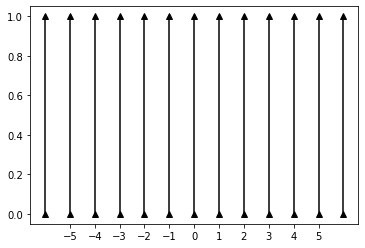

In [3]:
import matplotlib.pyplot as pl
import numpy as np
def example_function(x):
    return 0.6*np.cos(np.pi*2*0.23*x) + 0.4*np.sin(np.pi*2*0.1*x)

def plot_sampling_functions():
    fs = 12.0
    
    f = pl.figure(figsize = (20, 4))
    
    ax1 = f.add_subplot(131)
    x = np.linspace(-6, 6, 13)
    xticks = ['...']
    for x_ in x:
        ax1.plot([x_, x_], [0, 1], 'k^-')
        xticks.append(r'%dr$_{x}$'%x_)
    xticks.append('...')
    pl.xticks(np.linspace(-5, 5, 11), xticks, fontsize = fs)
    ax1.set_ylim((0, 1.2))
    ax1.set_yticks([])
    ax1.set_title(r'comb$(x, r_{x}) = \frac{1}{r_{x}}\cdot\sum_{n = -\infty}^{\infty}\delta\left(\frac{x}{r_{x}} - n\right)$', fontsize = fs)
    ax1.set_xlabel(r'$x$', fontsize = fs)
    ax1.spines['right'].set_visible(False), ax1.spines['top'].set_visible(False)
    
    ax3 = f.add_subplot(132)
    x_continous = np.linspace(-6, 6, 1000)
    f_continuous = example_function(x_continous)
    ax3.plot(x_continous, f_continuous, 'k-')
    ax3.set_xlim(-6, 6), ax3.set_ylim((-1.2, 1.2))
    pl.xticks([]), pl.yticks([])  
    ax3.set_title("Continuous Image\nf(x)", fontsize = fs)
    ax3.set_xlabel(r'$x$', fontsize = fs)
    ax3.spines['bottom'].set_position('center')
    ax3.spines['right'].set_visible(False), ax3.spines['top'].set_visible(False)
    
    ax4 = f.add_subplot(133)
    f_sampled = example_function(x)
    ax4.plot(x_continous, f_continuous, 'b--', lw = 1.0)
    for i in range(len(x)):
        ax4.plot([x[i], x[i]], [0, f_sampled[i]], 'ko-')
    ax4.set_xlim(-6, 6), ax4.set_ylim((-1.2, 1.2))
    pl.xticks([]), pl.yticks([])  
    ax4.set_title("Sampled Image\nf$_{s}$(x) = f(x) $\cdot$ comb$(x, r_{x})$", fontsize = fs)
    ax4.set_xlabel(r'$x$', fontsize = fs)
    ax4.spines['bottom'].set_position('center')
    ax4.spines['right'].set_visible(False), ax4.spines['top'].set_visible(False)
    
    pl.show()

plot_sampling_functions()

## Finite Apetures and Sampling Rates
 <ul>
 <li>What does this do for the image frequencies?<br><br>
 <li>We know that the ferquency components of a continuous function, $f(x)$, can be found from its Fourier transform:
 $$
     F(k_{x}) = \text{FT}\{f(x)\} = \int\limits_{-\infty}^{\infty}f(x)e^{-i2\pi k_{x}x}\text{d}x
 $$
 <li>So what is the Fourier transform of the sampled image:<br><br>
 \begin{align}
     F_{s}(k_{x}) &= \text{FT}\left\{f(x) \cdot  \text{comb}(x, r_{x}) \right\} \\\\
                  &= \text{FT}\left\{f(x)\right\} \circledast \text{FT}\left\{\text{comb}(x, r_{x})\right\} \qquad \text{(Convolution Theorem)}\\\\
                  &= F(k_{x})  \circledast \left\{r_{x}\cdot\text{comb}\left(k_{x}, 1/r_{x}\right)\right\}
 \end{align}<br>
 
 <li>The first of these terms is the frequency spectrum of the true (unsampled) scene. <br><br>
 <li>The second term means that the frequency spectrum is repeated with periods of $\frac{1}{r_{x}}$.  This can lead to __aliasing__, which degrades the final image quality.
</ul>

## The Nyquist-Shannon Theorem
 - Consider the illustration below, which demonstrates the effect of convolving the continuous imaging frequency spectrum with a comb function with spacing 1 / r$_{x}$. <br><br>
 - Due to the overlap of the periodic spectra, any frequencies with $|k_{x}| > \frac{1}{2r_{x}}$ are affected by overlap with the next repetation of frequencies.  <br><br>
 - The __badnwidth__ of such a system is thus $\Omega = \frac{1}{2r_{x}}$ (this can be thought of as the field-of-view of the frequency domain).<br><br>
 - Any frequencies in the image greater than this limit cannot be resolved!

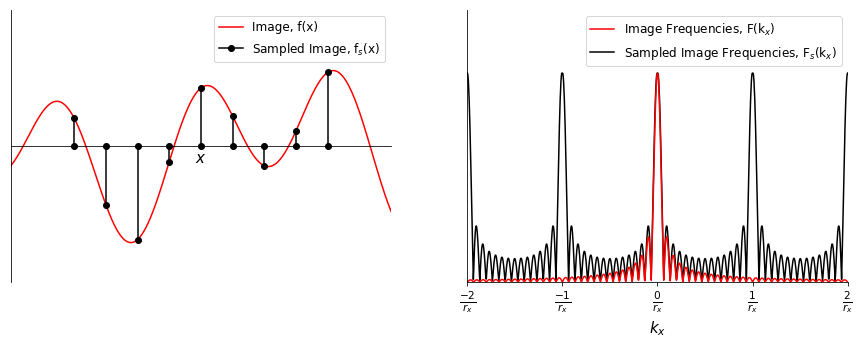

In [14]:
fs = 15.0
    
x_sampled = np.linspace(-4, 4, 9)
x_continous = np.linspace(-6, 6, 1000)

f_continuous = example_function(x_continous)
f_sampled = example_function(x_sampled)

# Note!  These data are fake and for illiustrative purposes only.
F_continuous = np.abs(np.sinc(5*x_continous))
F_sampled = F_continuous + np.roll(F_continuous, -len(F_continuous)/4) + np.roll(F_continuous, len(F_continuous)/4) + np.roll(F_continuous, -len(F_continuous)/2)
F_sampled = F_sampled / F_sampled.max()

f = pl.figure(figsize = (15, 5))

ax1 = f.add_subplot(121)
ax1.plot(x_continous, f_continuous, 'r-', label = "Image, f(x)", zorder = 1)

for i in range(len(x_sampled)):
    if i == 0:
        ax1.plot([x_sampled[i], x_sampled[i]], [0, f_sampled[i]], 'ko-', label = "Sampled Image, f$_{s}$(x)", zorder = 2)
    else:
        ax1.plot([x_sampled[i], x_sampled[i]], [0, f_sampled[i]], 'ko-', zorder = 2)


ax1.set_xlim(-6, 6), ax1.set_ylim((-1.4, 1.4))
pl.xticks([]), pl.yticks([])  
ax1.set_xlabel(r'$x$', fontsize = fs)
ax1.spines['bottom'].set_position('center')
ax1.spines['right'].set_visible(False), ax1.spines['top'].set_visible(False)
pl.legend(loc = 1, fontsize = 12)

ax2 = f.add_subplot(122)
ax2.plot(x_continous, F_continuous, 'r-', label = "Image Frequencies, F(k$_{x}$)", zorder = 2)
ax2.plot(x_continous, F_sampled, 'k-', label = "Sampled Image Frequencies, F$_{s}$(k$_{x}$)", zorder = 1)
ax2.set_xlim(-6, 6), ax2.set_ylim((0, 1.3))
pl.yticks([]), pl.xticks([-6, -3, 0, 3, 6], ["$\\frac{-2}{r_{x}}$", "$\\frac{-1}{r_{x}}$", "$\\frac{0}{r_{x}}$", "$\\frac{1}{r_{x}}$", "$\\frac{2}{r_{x}}$"], fontsize = fs)  
ax2.set_xlabel(r'$k_{x}$', fontsize = fs)
ax2.spines['right'].set_visible(False), ax2.spines['top'].set_visible(False)
pl.legend(loc = 1, fontsize = 12)

pl.show()

## Aliasing
 - For sampling frequencies $\frac{1}{r_{x}} \leq 2\Omega$, then the signal becomes __aliased__: 

In [25]:
freqeuncy_slider = FloatSlider(min=0.0, max=120, step=0.5, value=30, continuous_update=False)
sampling_freqeuncy_slider = FloatSlider(min=0.0, max=300, step=1, value=300, continuous_update=False)
    
# decorate the plot function with an environment from the UIs:
@interact(frequency=freqeuncy_slider, sample_freq = sampling_freqeuncy_slider)
def convolute_PSF(frequency, sample_freq):
    
    f = pl.figure(figsize = (15, 6))
    
    x_full = np.linspace(-0.5, 0.5, 1000)
    signal_full = np.cos(2*np.pi*x_full*frequency)
    
    x_sampled = np.linspace(-0.5, 0.5, int(sample_freq)+1)
    signal_sampled = np.cos(2*np.pi*x_sampled*frequency)
    
    ax1 = f.add_subplot(121)
    ax1.plot(x_full, signal_full, 'k-', lw = 2.0)
    ax1.plot(x_sampled, signal_sampled, 'ro', ms = 4)
    ax1.set_xlabel("x")
    
    ax2 = f.add_subplot(122)
    ax2.plot(x_sampled, signal_sampled, 'k-', lw = 2.0)
    ax2.set_xlabel("x")
    
    pl.show()

interactive(children=(FloatSlider(value=30.0, continuous_update=False, description=u'frequency', max=120.0, step=0.5), FloatSlider(value=300.0, continuous_update=False, description=u'sample_freq', max=300.0, step=1.0), Output()), _dom_classes=('widget-interact',))

## Aliasing
 - What does this mean for images?

In [12]:
# Convert the red-channel of the 'face' to a floating point array (value 0 to 1):
face_R = face[:, :, 0].astype('float32')/255

sample_slider = IntSlider(min=1, max=20, step=1, value=1, continuous_update=False)
    
# decorate the plot function with an environment from the UIs:
@interact(sample_rate=sample_slider)
def aliasing(sample_rate):
    
    f = pl.figure(figsize = (10, 10))
    ax = f.add_subplot(111)
    ax.imshow(face_R[0::sample_rate, 0::sample_rate], cmap = 'gray', interpolation = 'None')
    ax.set_xticks([]), ax.set_yticks([])
    pl.show()

interactive(children=(IntSlider(value=1, continuous_update=False, description=u'sample_rate', max=20, min=1), Output()), _dom_classes=('widget-interact',))

## Anti-Aliasing 
- To help remove the effects of aliasing, one approach is to blur the images first (pre-sample blurring).<br>
- Why does this work?

In [6]:
from skimage.morphology import disk
from skimage.filters import rank

# Convert the red-channel of the 'face' to a floating point array (value 0 to 1):
face_R = face[:, :, 0].astype('float32')/255

blur_sample_slider = IntSlider(min=1, max=20, step=1, value=1, continuous_update=False)
blur_window_slider = IntSlider(min=1, max=20, step=1, value=1, continuous_update=False)
    
# decorate the plot function with an environment from the UIs:
@interact(sample_rate=blur_sample_slider, blur_window = blur_window_slider)
def blur_aliasing(sample_rate, blur_window):
    
    element = disk(blur_window)
    face_R_blur = rank.mean(face_R, selem=element)
    
    f = pl.figure(figsize = (12, 10))
    
    ax1 = f.add_subplot(121)
    ax1.imshow(face_R[0::sample_rate, 0::sample_rate], cmap = 'gray', interpolation = 'None')
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title("Original Image")
    
    ax2 = f.add_subplot(122)
    ax2.imshow(face_R_blur[0::sample_rate, 0::sample_rate], cmap = 'gray', interpolation = 'None')
    ax2.set_xticks([]), ax2.set_yticks([])
    ax2.set_title("Blurred Image")
    
    pl.tight_layout()
    
    pl.show()

interactive(children=(IntSlider(value=1, continuous_update=False, description=u'sample_rate', max=20, min=1), IntSlider(value=1, continuous_update=False, description=u'blur_window', max=20, min=1), Output()), _dom_classes=('widget-interact',))

## Bandwidth
 - We are missing one component!<br><br>
 - We now know that any frequencies $|k_{x}| > \frac{1}{2r_{x}}$ should be ignored.<br><br>
 - Our imaging system is there __bandlimited__:
 $$
     -\frac{1}{2r_{x}} < k_{x} < \frac{1}{2r_{x}}
 $$
 - This is equivalent to multiplying the full frequency space with a __rectangle function__:
 $$
     F^{*}_{s}(k_{x}) = \text{rect}(k_{x}\cdot r_{x}) \cdot F_{s}(k_{x})
 $$

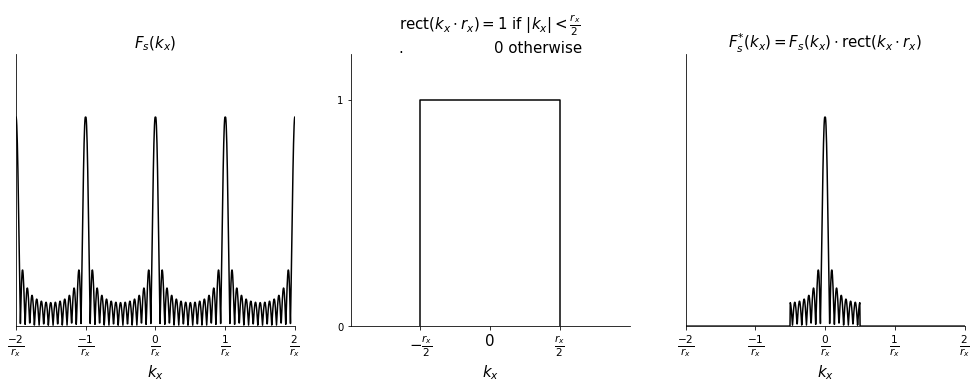

In [19]:
def plot_bandlimited():
    
    fs = 15.0

    x_continous = np.linspace(-6, 6, 1000)
    F_continuous = np.abs(np.sinc(5*x_continous))
    F_sampled = F_continuous + np.roll(F_continuous, -len(F_continuous)/4) + np.roll(F_continuous, len(F_continuous)/4) + np.roll(F_continuous, -len(F_continuous)/2)
    F_sampled = F_sampled / F_sampled.max()

    f = pl.figure(figsize = (17, 5))

    ax1 = f.add_subplot(131)
    ax1.plot(x_continous, F_sampled, 'k-', label = "Sampled, $F(k_{x})$", zorder = 1)
    ax1.set_xlim(-6, 6), ax1.set_ylim((0, 1.3))
    pl.yticks([]), pl.xticks([-6, -3, 0, 3, 6], ["$\\frac{-2}{r_{x}}$", "$\\frac{-1}{r_{x}}$", "$\\frac{0}{r_{x}}$", "$\\frac{1}{r_{x}}$", "$\\frac{2}{r_{x}}$"], fontsize = fs)  
    ax1.set_xlabel(r'$k_{x}$', fontsize = fs)
    ax1.spines['right'].set_visible(False), ax1.spines['top'].set_visible(False)
    ax1.set_title("$F_{s}(k_{x})$", fontsize = fs)
    
    ax2 = f.add_subplot(132)
    ax2.plot([-0.5, -0.5, 0.5, 0.5], [0, 1, 1, 0], 'k-')
    pl.xticks((-0.5, 0, 0.5), (r'$-\frac{r_{x}}{2}$', '0', r'$\frac{r_{x}}{2}$'), fontsize = fs)
    ax2.set_xlim(-1, 1), ax2.set_ylim((0, 1.2))
    pl.yticks([0, 1])  
    ax2.set_title("rect$(k_{x} \cdot r_{x}) = 1 $ if $|k_{x}| < \\frac{r_{x}}{2}$\n.                   0 otherwise", fontsize = fs)
    ax2.set_xlabel(r'$k_{x}$', fontsize = fs)
    ax2.spines['right'].set_visible(False), ax2.spines['top'].set_visible(False)
    
    ax3 = f.add_subplot(133)
    F_sampled[np.abs(x_continous) > 1.5] = 0
    ax3.plot(x_continous, F_sampled, 'k-')
    ax3.set_xlim(-6, 6), ax3.set_ylim((0, 1.3))
    pl.yticks([]), pl.xticks([-6, -3, 0, 3, 6], ["$\\frac{-2}{r_{x}}$", "$\\frac{-1}{r_{x}}$", "$\\frac{0}{r_{x}}$", "$\\frac{1}{r_{x}}$", "$\\frac{2}{r_{x}}$"], fontsize = fs)  
    ax3.set_xlabel(r'$k_{x}$', fontsize = fs)
    ax3.spines['right'].set_visible(False), ax3.spines['top'].set_visible(False)
    ax3.set_title("$F^{*}_{s}(k_{x}) = F_{s}(k_{x})\cdot$rect($k_{x}\cdot r_{x}$)", fontsize = fs)

    pl.show()
    
plot_bandlimited()

## Bandwidth
 Our image is the inverse FT of this function:<br><br>
 \begin{align}
     f_{s}(x) &= \text{FT}^{-1}\left\{F_{s}(k_{x})\cdot\text{rect}(k_{x}\cdot r_{x})\right\}\\
              &= \text{FT}^{-1}\left\{F_{s}(k_{x})\right\}\circledast\text{FT}^{-1}\left\{\text{rect}(k_{x}\cdot r_{x})\right\}\\
              & = (f(x) \cdot  \text{comb}(x, r_{x})) \circledast \text{sinc}\left(\frac{x}{r_{x}}\right) \qquad \text{(Whittaker-Shannon interpolation formula in 1D)}
 \end{align}

In [43]:
rx_slider = IntSlider(min=1, max=40, step=1, value=1, continuous_update=False, description = '\(r_{x}\)')

@interact(rx=rx_slider)
def demo_sinc_conv(rx):

    face_ds = face_R[0::5, 0::5]
    
    x = np.arange(-face_ds.shape[0]/8, +face_ds.shape[0]/8)
    X, Y = np.meshgrid(x, x)

    f = pl.figure(figsize = (25, 7))
    
    # Sinc/sombrero function
    r = np.sqrt(X**2 + Y**2)
    kernel = np.sinc(r / (0.1*rx))
    ax = f.add_subplot(111)
    ax.imshow(convolve2d(face_ds, kernel), cmap = 'gray')
    ax.set_xticks([]), ax.set_yticks([])

    pl.show()

interactive(children=(IntSlider(value=1, continuous_update=False, description=u'\\(r_{x}\\)', max=40, min=1), Output()), _dom_classes=('widget-interact',))

## Discrete Sampling
- For discrete images, this gives us an important relationship between the resolution and field-of-view of image and frequency spaces:
<img src="https://github.com/mdblackledge/theoryofimaging/blob/main/Lecture_2/images/FOV_resolution_freq.jpg&raw=true width = 800>